In [1]:
import numpy as np
import pandas as pd
import cvxpy as cvx
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize, LinearConstraint
from scipy.sparse import csr_matrix, coo_matrix
import networkx as nx
import urllib.request
import gzip
import shutil
import random

# Task 1

# Simplex projection

https://stats.stackexchange.com/questions/4608/gradient-of-hinge-loss

http://www.mit.edu/~rakhlin/6.883/lectures/lecture04.pdf

https://arxiv.org/pdf/1101.6081.pdf

https://see.stanford.edu/materials/lsocoee364b/hw4sol.pdf

http://www.mcduplessis.com/index.php/2016/08/22/fast-projection-onto-a-simplex-python/

https://math.stackexchange.com/questions/1933485/orthogonal-projection-onto-the-unit-simplex-with-the-following-form-x-i

In [2]:
def proj(a, y):
    '''took implementation from http://www.mcduplessis.com/index.php/2016/08/22/fast-projection-onto-a-simplex-python/
    '''
    l = y/a
    idx = np.argsort(l)
    d = len(l)
    evalpL = lambda k: np.sum(a[idx[k:]]*(y[idx[k:]] - l[idx[k]]*a[idx[k:]]) ) -1
    def bisectsearch():
        idxL, idxH = 0, d-1
        L = evalpL(idxL)
        H = evalpL(idxH)
        if L<0:
            return idxL
        while (idxH-idxL)>1:
            iMid = int((idxL+idxH)/2)
            M = evalpL(iMid)
            if M>0:
                idxL, L = iMid, M
            else:
                idxH, H = iMid, M
        return idxH
    k = bisectsearch()
    lam = (np.sum(a[idx[k:]]*y[idx[k:]])-1)/np.sum(a[idx[k:]])
    x = np.maximum(0, y-lam*a)
    return x

In [3]:
def proj_simplex_cvxpy(a, y):
    d = len(a)
    # setup the objective and constraints and solve the problem
    x = cvx.Variable(d)
    obj = cvx.Minimize(cvx.sum_squares(x - y))
    constr = [x >= 0, a*x == 1]
    prob = cvx.Problem(obj, constr)
    prob.solve()
    return np.array(x.value).squeeze()

In [4]:
def proj_unit(x):
    a = np.ones_like(x)
    return proj_simplex_cvxpy(a, x)

In [5]:
def proj_unit_approx(x):
    a = np.ones_like(x)
    return proj(a, x)

# Figure out relationship (1a)

Prove $argmin_x ||x-z||^2$ = argmin_

# Solution

In [6]:
def full_f(x, a_list):
    f_sum = 0
    for a_i in a_list:
        f_sum += max(1 - np.dot(a_i, x), 0)
    f_avg = f_sum / len(a_list)
    return f_avg

In [7]:
def get_single_param_f(a_list):
    def single_param_f(x):
        return full_f(x, a_list)
    return single_param_f

In [8]:
n_summands = 150  # N
n_dims = 50  # m

In [9]:
a_list = []
for i in range(n_summands):
    a_i = np.random.normal(size=n_dims)
    a_list.append(a_i)

# Optimize using built-in methods first

In [10]:
# constraints = []
# constraints.append(LinearConstraint(np.ones((1, n_dims)), 1, 1, keep_feasible=True))  # keep_feasible value?
# for i in range(n_dims):
#     A = np.zeros((1, n_dims))
#     A[0, i] = 1
#     constraints.append(LinearConstraint(A, 0, np.inf, keep_feasible=True))


# for i in range(n_dims):
#     jac = np.zeros(n_dims)
#     jac[i] = 1
#     constraints.append({'type': 'ineq', 'fun': lambda x: x[i], 'jac': lambda x: jac})

# constraints.append({'type': 'ineq', 'fun': lambda x: (x >= 0).all()})


# import cvxpy.atoms
# x = cvx.Variable(n_dims)
# cvx.Minimize(np.array([cvx.max(1 - np.dot(a_i, x), 0) for a_i in a_list]).mean())

In [11]:
constraints = []
constraints.append({'type': 'eq', 'fun': lambda x: x.sum() - 1, 'jac': lambda x: np.ones(n_dims)})
constraints.append({'type': 'ineq', 'fun': lambda x: x})

x_init = np.random.dirichlet(alpha=np.ones(n_dims))
f = get_single_param_f(a_list)
result = minimize(f, x_init, constraints=constraints)
f_star = result['fun']
x_star = result['x']
print(f_star)

0.8513243266987647


# SGD with projections

In [12]:
x_cur = np.random.dirichlet(alpha=np.ones(n_dims))
x_best = x_cur
f_best = f(x_best)
iters = 10000
vals = []
for iter_i in trange(iters):
    i = np.random.randint(0, n_summands)
    a_i = a_list[i]
    dot = np.dot(a_i, x_cur)
    if dot >= 1:
        vals.append(vals[-1])
        continue
        
    grad = -a_i
    # "Dimension of simplex, right. K is number of current iteration" - Ivan Zorin
    eta = 1 / np.sqrt(n_dims * (iter_i+1))
    x_raw = x_cur - eta * grad
    x_cur = proj_unit_approx(x_raw)
    val = f(x_cur)
    if val < f_best:
        x_best = x_cur
        f_best = val
    vals.append(val)
vals = np.array(vals)

100%|██████████| 10000/10000 [00:01<00:00, 5465.37it/s]


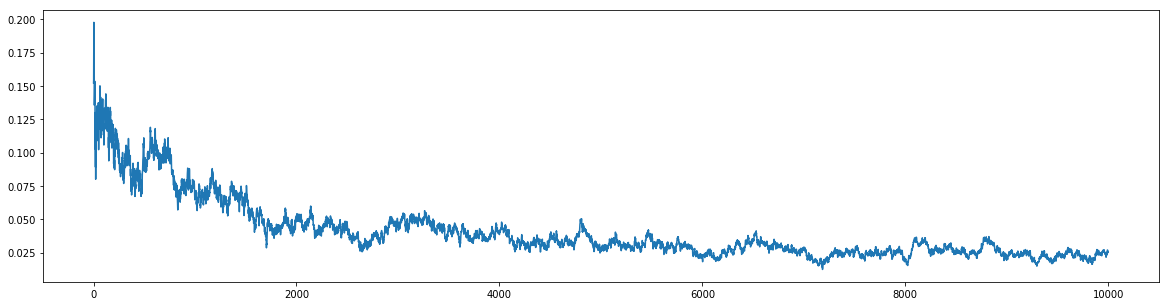

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(vals - f_star)

In [14]:
sparsity_index = (x_best < 10**(-4)).sum() / len(x_best)
print(sparsity_index)

0.4


# Dual averaging

In [38]:
x_cur = np.random.dirichlet(alpha=np.ones(n_dims))
x_best = x_cur
f_best = f(x_best)
iters = 10000
vals = []
theta = 0
for iter_i in trange(iters):
    i = random.randint(0, n_summands-1)
    a_i = a_list[i]
    dot = np.dot(a_i, x_cur)
    if dot >= 1:
        vals.append(vals[-1])
        continue
        
    grad = -a_i
    theta += grad
    eta = 1 / np.sqrt(iter_i+1)
    z = theta * eta
    x_cur = proj_unit_approx(z)
    val = f(x_cur)
    if val < f_best:
        x_best = x_cur
        f_best = val
    vals.append(val)
vals = np.array(vals)

  0%|          | 0/10000 [00:00<?, ?it/s]


ValueError: shapes (50,) and (325729,) not aligned: 50 (dim 0) != 325729 (dim 0)

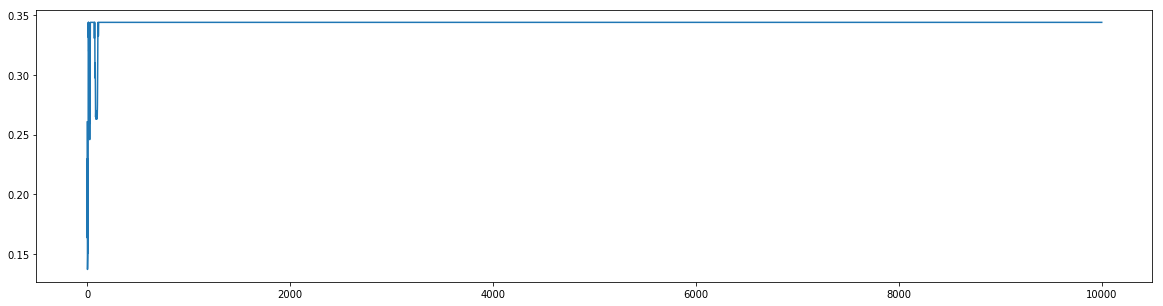

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(vals - f_star)

In [17]:
sparsity_index = (x_best < 10**(-4)).sum() / len(x_best)
print(sparsity_index)

0.92


# Task 2

In [18]:
n_dims = 10

In [19]:
np.random.seed(42)
A = np.random.normal(size=(n_dims, n_dims))
b = np.random.normal(size=n_dims)
x_cur = np.random.normal(size=n_dims)

In [20]:
np.linalg.multi_dot([x.T, A.T, A, x]) - np.dot(b.T, x)

NameError: name 'x' is not defined

In [21]:
def f(x):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-21-11563effd304>, line 2)

# Task 3

# Find dual problem (a)

$L(x, \lambda) = ||x - P^Tx||^2 - \sum_1^n \lambda_i x_i + \lambda_{n+1} (1^Tx - 1), \lambda \geq 0$

Dual problem: $g(\lambda) = inf_x L(x, \lambda) \to \max$

# Target function definitions

In [22]:
def full_f(x, m):
    return np.linalg.norm(x - m.T.dot(x)) ** 2

In [23]:
def get_single_param_f(m):
    def f(x):
        return full_f(x, m)
    return f

# Create graph and target function

In [24]:
n_dims = 1000

In [25]:
avg_degree = 10
degrees = np.random.poisson(lam=avg_degree, size=n_dims)
if degrees.sum() % 2 == 1:
    degrees[0] += 1

In [26]:
G = nx.configuration_model(degrees)  # it generates a symmetric graph and I need a nonsymmetric one!

In [27]:
m = nx.to_scipy_sparse_matrix(G)

In [28]:
f = get_single_param_f(m)

# Use graph from Stanford webgraph collection (d)

In [29]:
# download and unarchive the data (only one time)

url = 'https://snap.stanford.edu/data/web-NotreDame.txt.gz'
graph_gz_path = 'web-NotreDame.txt.gz'
graph_path = 'web-NotreDame.txt'

urllib.request.urlretrieve(url, graph_gz_path)

with gzip.open(graph_gz_path, 'rb') as f_in:
    with open(graph_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [30]:
text_file = open(graph_path, "r")
lines = text_file.readlines()
lines = lines[4:]  # skip introductory comments (works only for specified graph txt)

In [31]:
i = []
j = []
for line in tqdm(lines):
    cur_indices = [int(index) for index in line.replace('\n', '').split('\t')]
    i.append(cur_indices[0])
    j.append(cur_indices[1])
i = np.array(i)
j = np.array(j)

100%|██████████| 1497134/1497134 [00:01<00:00, 1096388.39it/s]


In [32]:
filling = np.ones(len(lines))
n_dims = 325729  # n_nodes

In [33]:
m = coo_matrix((filling, (i, j)), shape=(n_dims, n_dims)).tocsr()

In [34]:
f = get_single_param_f(m)

# SGD

In [35]:
# x_cur = np.random.normal(scale=50, size=(n_dims))
x_cur = np.random.normal(size=(n_dims))
x_best = x_cur
f_best = f(x_best)
iters = 10000
vals = []
for iter_i in trange(iters):
    i = np.random.randint(0, n_dims)
    
    identity_row = np.zeros((n_dims))
    identity_row[i] = 1
    dense_row = np.array(m[:, i].todense()).reshape((n_dims))
    transition_row = identity_row - dense_row  # row of I minus (column of P which is row of P^T)
    grad = np.dot(transition_row, x_cur) * 2 * transition_row

    eta = 1 / np.sqrt(iter_i+1)
    x_raw = x_cur - eta * grad
    x_cur = proj_unit_approx(x_raw)
    val = f(x_cur)
    if val < f_best:
        x_best = x_cur
        f_best = val
    vals.append(val)
vals = np.array(vals)

100%|██████████| 10000/10000 [11:11<00:00, 14.90it/s]


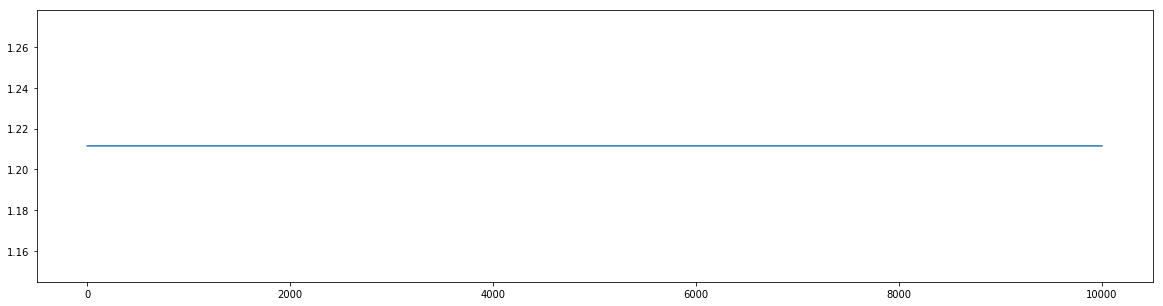

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(vals)

# Dual ascent

In [525]:
def lagr(x):
    return f(x) - np.dot(lam[:-1], x) + lam[-1] * (x.sum() - 1)

In [526]:
def g(lam):
    x_init = np.random.normal(size=(n_dims))
    result = minimize(lagr, x_init)
    f_star = result['fun']
    x_star = result['x']
    return x_star, f_star

In [ ]:
# one iteration just for debug

In [ ]:
# first n_dims elems should be non-negative, let's make the last one non-negative too for convenience
lam = np.random.exponential(scale=0.5, size=n_dims + 1)

In [ ]:
iter_i = 0

In [430]:
grad = np.concatenate([-x_star, [x_star.sum() - 1]])

In [431]:
eta = 1 / np.sqrt(iter_i+1)

In [432]:
lam += eta * grad
lam *= (lam > 0)

In [527]:
# first n_dims elems should be non-negative, let's make the last one non-negative too for convenience
lam = np.random.exponential(scale=0.5, size=n_dims + 1)
lam_best = lam
x_star, f_star = g(lam_best)
f_best = f_star
iters = 100
vals = []
for iter_i in trange(iters):
    x_star, f_star = g(lam)
    grad = np.concatenate([-x_star, [x_star.sum() - 1]])

    eta = (10 ** (-3)) / np.sqrt(iter_i+1)
#     eta = 10**(-3)
    lam += eta * grad
    lam *= (lam > 0)
    
    if f_star > f_best:
        lam_best = lam
        f_best = f_star
    vals.append(f_star)
vals = np.array(vals)

KeyboardInterrupt: 

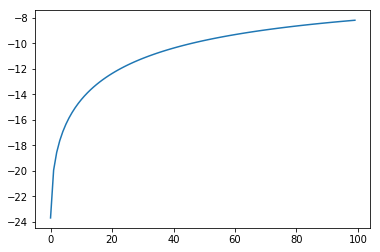

In [443]:
plt.plot(vals)